## env

In [1]:
!nvidia-smi -L
!nvcc -V
!nvidia-smi

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-adca11fa-b2f9-4ba3-b716-cd100dd0678e)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-6319f61b-e1e5-7ae2-aedc-4e814e50b2e7)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-5b43cfa6-7525-be5c-818f-24671670dd7b)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-8aa77525-9a07-ffa2-ac93-b35a7c23ec8a)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Wed Jul 20 03:52:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|========

In [23]:
import os
# TF_ENABLE_ONEDNN_OPTS=0
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import sys
sys.path.append('CNN/Code/code/')
from load_data import load_MEG_dataset
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.cuda import amp
import torch.nn.functional as F
import math
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
from scipy.integrate import simps
from mne.time_frequency import psd_array_welch
from band_power import (
    bandpower_multi_bands,
    standard_scaling_sklearn,
)

In [3]:
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Mnet

## Load

In [4]:
Split = 0.90
X_train, y_train = load_MEG_dataset([str(i).zfill(3) for i in range(1,2)], mode = 'concatenate', output_format='numpy',shuffle = False, training=True, train_test_split=Split, batch_size=500)
X_test, y_test = load_MEG_dataset([str(i).zfill(3) for i in range(1,2)], mode = 'concatenate', output_format='numpy',shuffle = False, training=False, train_test_split=Split, batch_size=500)

X_train = X_train[:, None, ...]
X_test = X_test[:, None, ...]

# X_train=np.repeat(X_train,8,axis=3)
# X_test=np.repeat(X_test,8,axis=3)

y_train = (y_train / 2) - 1
y_test = (y_test / 2) - 1

X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
y_train_tensors = torch.from_numpy(y_train) 
y_test_tensors = torch.from_numpy(y_test)
# y_train_tensors = F.one_hot(y_train_tensors)
# y_test_tensors = F.one_hot(y_test_tensors)

Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------


In [5]:
X_train_tensors = F.interpolate(X_train_tensors, size=(272, 800))
X_test_tensors = F.interpolate(X_test_tensors, size=(272, 800))
print(X_train_tensors.shape)

torch.Size([810, 1, 272, 800])


In [6]:
X_train_tensors=X_train_tensors.cuda()
X_test_tensors=X_test_tensors.cuda()
y_train_tensors=y_train_tensors.cuda()
y_test_tensors=y_test_tensors.cuda()
print('done')

/users/k21116947/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA A100-SXM4-40GB with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A100-SXM4-40GB GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


done


In [7]:
X_train_tensors.shape

torch.Size([810, 1, 272, 800])

## band power 

In [8]:
X = np.swapaxes(X_train, 2, -1).squeeze()
data = X[X.shape[0]-1, 70, :]
psd_mne, freqs_mne = psd_array_welch(data, 250, 1., 70., n_per_seg=None,
                          n_overlap=0, n_jobs=1)
for low, high in [(1, 4), (4, 8), (8, 10), (10, 13), (13, 30),
                  (30, 70)]:
    print("processing bands (low, high) : ({},{})".format(low, high))
    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs_mne >= low, freqs_mne <= high)
      # Frequency resolution
    freq_res = freqs_mne[1] - freqs_mne[0]  # = 1 / 4 = 0.25

    # Compute the absolute power by approximating the area under the curve
    power = simps(psd_mne[idx_delta], dx=freq_res)
    print('Absolute power: {:.4f} uV^2'.format(power))
    
    total_power = simps(psd_mne, dx=freq_res)
    rel_power = power / total_power
    
    print('Relative power: {:.4f}'.format(rel_power))

Effective window size : 1.024 (s)
processing bands (low, high) : (1,4)
Absolute power: 0.2035 uV^2
Relative power: 0.5719
processing bands (low, high) : (4,8)
Absolute power: 0.0403 uV^2
Relative power: 0.1131
processing bands (low, high) : (8,10)
Absolute power: 0.0012 uV^2
Relative power: 0.0035
processing bands (low, high) : (10,13)
Absolute power: 0.0040 uV^2
Relative power: 0.0113
processing bands (low, high) : (13,30)
Absolute power: 0.0175 uV^2
Relative power: 0.0491
processing bands (low, high) : (30,70)
Absolute power: 0.0314 uV^2
Relative power: 0.0883


In [9]:
X_train_bp = np.squeeze(X_train, axis=1)
# X_train_bp = X_train_bp[: :, :, :]
X_train_bp = standard_scaling_sklearn(X_train_bp)
X_test_bp = np.squeeze(X_test, axis=1)
# X_train_bp = X_train_bp[: :, :, :]
X_test_bp = standard_scaling_sklearn(X_test_bp)
bands = [(1, 4), (4, 8), (8, 10), (10, 13), (13, 30), (30, 70)]
bp_train = bandpower_multi_bands(X_train_bp, fs=100.0, bands=bands, relative=True)
bp_test = bandpower_multi_bands(X_test_bp, fs=100.0, bands=bands, relative=True)
bp_train_tensor = torch.Tensor(bp_train).cuda()
bp_test_tensor = torch.Tensor(bp_test).cuda()

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective wind

## Parms

In [10]:
CRED    = '\33[31m'
CGREEN  = '\33[32m'
CYELLOW = '\33[33m'
CBLUE   = '\33[34m'

## Functions

In [11]:
class ChannelPool(nn.Module):

    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1),
                          torch.mean(x, 1).unsqueeze(1)), dim=1)

In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int):
                How long to wait after last time validation loss improved.
                Default: 7
            verbose (bool):
                If True, prints a message for each validation loss improvement.
                Default: False
            delta (float):
                Minimum change in the monitored quantity to qualify as an improvement.
                Default: 0
            path (str):
                Path for the checkpoint to be saved to.
                Default: 'checkpoint.pt'
            trace_func (function):
                trace print function.
                Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.spatialAttention = nn.Sequential(
            ChannelPool(),
            nn.Conv2d(2, 1, 7, 7, padding=3),
            nn.Sigmoid(),
            )

    def forward(self, x):
        attention = self.spatialAttention(x)
        # print(attention.shape)
        # print(x.shape)
        return x * attention


In [14]:
class Flatten_MEG(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [15]:
class ChannelAttention(nn.Module):
    """
            Implementation of a channel attention module.
        """
    class Showsize(nn.Module):
        def __init__(self):
            super(ChannelAttention.Showsize, self).__init__()
        def forward(self, x):
            # print(x.shape)
            return x

    def __init__(self, shape, reduction_factor=16):

        super(ChannelAttention, self).__init__()

        _, in_channel, h, w = shape
        self.mlp = nn.Sequential(
            # self.Showsize(),
            Flatten_MEG(),
            # self.Showsize(),
            nn.Linear(in_channel, in_channel // reduction_factor),
            nn.ReLU(),
            nn.Linear(in_channel // reduction_factor, in_channel),
        )
        self.avg = nn.AvgPool2d(kernel_size=(h, w), stride=(h, w))
        self.max = nn.MaxPool2d(kernel_size=(h, w), stride=(h, w))

    def forward(self, x):
        print('x', x.shape)
        avg = self.avg(x)
        max = self.max(x)
        sum = self.mlp(avg) + self.mlp(max)
        # print(sum.shape)
        attention = (
            torch.sigmoid(sum)
            .unsqueeze(2)
            .unsqueeze(3)
        )
        print('att', attention.shape)
        return x * attention


In [16]:
class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, x, bp):

        # min_ = x.min(1, keepdim=True)[0]
        # if min_[0] < 0:
        #     x = x + min_
        # else:
        #     x = x - min_
        # x = x / x.max()
        x = x.view(x.shape[0], -1)
        bp = bp.view(bp.shape[0], -1)
        x = torch.cat([x, bp], -1)

        return x

In [17]:
def GETcorrectnumber(loader, printcolor):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(num_classes)]
        n_class_samples = [0 for i in range(num_classes)]
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = rpsmnet(inputs)
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            # n_correct += (predicted == labels).sum().item()
            for k in range(predicted.shape[0]):
                if predicted[k]==labels[k]:
                    n_correct +=1
            # for i in range(num_classes): # accuracy for each class
            #     label = labels[i]
            #     pred = predicted[i]
            #     if (label == pred):
            #         n_class_correct[i] += 1
            #     n_class_samples[i] += 1
        acc = 100.0 * n_correct / n_samples
        print(printcolor+f'[{epoch + 1}] t accuracy： {acc}%'+printcolor)
    return acc

## RPS_Mnet

In [18]:
# class RPS_MNet(nn.Module):
#     """
#         Model inspired by [Aoe at al., 10.1038/s41598-019-41500-x] integrated with bandpower.
#     """
#     class Showsize(nn.Module):
#         def __init__(self):
#             super(RPS_MNet.Showsize, self).__init__()
#         def forward(self, x):
#             # print(x.shape)
#             return x

#     def __init__(self, n_times):
#         """
#         Args:
#             n_times (int):
#                 n_times dimension of the input data.
#         """
#         super(RPS_MNet, self).__init__()
#         # if n_times == 501:  # TODO automatic n_times
#         #     self.n_times = 12
#         # elif n_times == 601:
#         #     self.n_times = 18
#         # elif n_times == 701:
#         #     self.n_times = 24
#         # else:
#         #     raise ValueError(
#         #         "Network can work only with n_times = 501, 601, 701 "
#         #         "(epoch duration of 1., 1.2, 1.4 sec),"
#         #         " got instead {}".format(n_times)
#         #     )
#         self.n_times = n_times
#         self.spatial = nn.Sequential(
#             nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(272,64), bias=False), #kernel size 204, 64
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             self.Showsize(),
#             nn.Conv2d(32, 64, stride=(1, 1), kernel_size=(1, 16), bias=False), # kernel size 1,16
#             nn.ReLU(),
#             self.Showsize(),
#             nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
#             nn.BatchNorm2d(64),
#             self.Showsize(),
#         )

#         self.temporal = nn.Sequential(
#             nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(8, 8), bias=False),
#             nn.ReLU(),
#             # nn.BatchNorm2d(32),
#             self.Showsize(),
#             nn.Conv2d(32, 32, stride=(1, 1), kernel_size=(8, 8), bias=False),
#             nn.ReLU(),
#             self.Showsize(),
#             nn.MaxPool2d(kernel_size=(5, 3), stride=(5, 3)),
#             # nn.BatchNorm2d(32),
#             self.Showsize(),
#             nn.Conv2d(32, 64, stride=(1, 1), kernel_size=(1, 4), bias=False),
#             nn.ReLU(),
#             # nn.BatchNorm2d(64),
#             self.Showsize(),
#             nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(1, 4), bias=False), #conv6
#             nn.ReLU(),
#             # nn.BatchNorm2d(64),
#             self.Showsize(),
#             nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
#             self.Showsize(),
#             nn.Conv2d(64, 128, stride=(1, 1), kernel_size=(1, 2), bias=False),
#             nn.ReLU(),
#             nn.Dropout2d(p=0.3),
#             # nn.BatchNorm2d(128),
#             self.Showsize(),
#             nn.Conv2d(128, 128, stride=(1, 1), kernel_size=(1, 2), bias=False),
#             nn.ReLU(),
#             nn.Dropout2d(p=0.3),
#             # nn.BatchNorm2d(128),
#             self.Showsize(),
#             nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
#             self.Showsize(),
#             nn.Conv2d(128, 256, stride=(1, 1), kernel_size=(1, 2), bias=False),
#             nn.ReLU(),
#             nn.Dropout2d(p=0.3),
#             # nn.BatchNorm2d(256),
#             self.Showsize(),
#             nn.Conv2d(256, 256, stride=(1, 1), kernel_size=(1, 2), bias=False), #conv10
#             nn.ReLU(),
#             nn.Dropout2d(p=0.3),
#             # nn.BatchNorm2d(256),
#             self.Showsize(),
#             nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
#             self.Showsize(),

#         )

#         # self.attention = nn.Sequential(
#         #     ChannelAttention([None, 256, 26, self.n_times]), SpatialAttention()
#         # )

#         self.concatenate = Concatenate()

#         self.flatten = Flatten_MEG()

#         self.ff1 = nn.Sequential(
#             # nn.Linear(256 * 26 * self.n_times + 272 * 6, 1024),
#             nn.Linear(30720, 1024),
#             nn.BatchNorm1d(num_features=1024),
#             nn.ReLU(),
#             self.Showsize(),
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(num_features=1024),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             self.Showsize(),
#         )
#         self.ff2 = nn.Sequential(
#             nn.Dropout(0.3),
#             nn.Linear(2656, 14),
#         )

#     def forward(self, x, pb):
#         x = self.spatial(x)
#         x = torch.transpose(x, 1, 2)
#         x = self.temporal(x)
#         # x = self.attention(x)
#         x = self.ff1(self.flatten(x))
#         x = self.concatenate(x, pb)
#         x = self.ff2(x)

#         return x.squeeze(1)

In [19]:
class RPS_MNet(nn.Module):
    """
        Model inspired by [Aoe at al., 10.1038/s41598-019-41500-x] integrated with bandpower.
    """
    class Showsize(nn.Module):
        def __init__(self):
            super(RPS_MNet.Showsize, self).__init__()
        def forward(self, x):
            # print(x.shape)
            return x
        
    def __init__(self, n_times):
        """
        Args:
            n_times (int):
                n_times dimension of the input data.
        """
        super(RPS_MNet, self).__init__()
        if n_times == 501:  # TODO automatic n_times
            self.n_times = 26
        elif n_times == 601:
            self.n_times = 18
        elif n_times == 701:
            self.n_times = 24
        else:
            raise ValueError(
                "Network can work only with n_times = 501, 601, 701 "
                "(epoch duration of 1., 1.2, 1.4 sec),"
                " got instead {}".format(n_times)
            )

        self.spatial = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=[272, 64], bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=[1, 16], bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[1, 2], stride=(1, 2)),
            # self.Showsize(),
            # nn.BatchNorm2d(64),
        )


        self.temporal = nn.Sequential(nn.Conv2d(1, 32, kernel_size=[8, 8], bias=True),
                                      nn.ReLU(),
                                      # self.Showsize(),
                                      # nn.BatchNorm2d(32),
                                      nn.Conv2d(32, 32, kernel_size=[8, 8], bias=True),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=[1, 3], stride=(1, 2)),
                                      # nn.BatchNorm2d(32),
                                      nn.Conv2d(32, 64, kernel_size=[6, 6], bias=True),
                                      nn.ReLU(),
                                      # nn.BatchNorm2d(64),
                                      nn.Conv2d(64, 64, kernel_size=[6, 6], bias=True),
                                      nn.ReLU(),
                                      # nn.BatchNorm2d(64),
                                      nn.MaxPool2d(kernel_size=[1, 2], stride=(1, 2)),
                                      nn.Conv2d(64, 128, kernel_size=[5, 5], bias=True),
                                      nn.ReLU(),
                                      nn.Dropout2d(p=0.3),
                                      # nn.BatchNorm2d(128),
                                      nn.Conv2d(128, 128, kernel_size=[5, 5], bias=True),
                                      nn.ReLU(),
                                      nn.Dropout2d(p=0.3),
                                      # nn.BatchNorm2d(128),
                                      nn.MaxPool2d(kernel_size=[1, 2], stride=(1, 2)),
                                      nn.Conv2d(128, 256, kernel_size=[4, 4], bias=True),
                                      nn.ReLU(),
                                      nn.Dropout2d(p=0.3),
                                      # nn.BatchNorm2d(256),
                                      nn.Conv2d(256, 256, kernel_size=[4, 4], bias=True),
                                      nn.ReLU(),
                                      nn.Dropout2d(p=0.3),
                                      # nn.BatchNorm2d(256),
                                      # self.Showsize(),
                                      )

        self.attention = nn.Sequential(
            ChannelAttention((None, 256, 26, self.n_times)),
        )

        self.attention2 = nn.Sequential(
            SpatialAttention(),
        )

        self.concatenate = Concatenate()

        # self.flatten = Flatten_MEG()

        self.ff = nn.Sequential(
            nn.Linear(256 * 26 * self.n_times + 272 * 6, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 14),
        )

    def forward(self, x, pb):
        x = self.spatial(x)
        x = torch.transpose(x, 1, 2)
        x = self.temporal(x)
        x = self.attention(x)
        x = self.attention2(x)
        x = self.concatenate(x, pb)
        x = self.ff(x)

        return x.squeeze(1)

In [20]:
rpsmnet = RPS_MNet(501).cuda()
print(rpsmnet)

RPS_MNet(
  (spatial): Sequential(
    (0): Conv2d(1, 32, kernel_size=(272, 64), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(1, 16), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[1, 2], stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (temporal): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(8, 8), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[1, 3], stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[1, 2], stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (11): ReLU()
    (12): Dropout2d(p=0.3, inplace=False)
    (13): Conv2d(128, 128, kernel_size=(5, 5), stride=(1,

## Train

In [21]:
BATCH_SIZE=80
num_epochs=10000
train = Data.TensorDataset(X_train_tensors, y_train_tensors, bp_train_tensor)
test = Data.TensorDataset(X_test_tensors, y_test_tensors, bp_test_tensor)
train_loader = Data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = Data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

learning_rate = 0.0005
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rpsmnet.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(rpsmnet.parameters(), lr=learning_rate, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [25]:
from torch.utils.tensorboard import SummaryWriter
summary_writer = SummaryWriter(f'./models/test')
# valid_loss = []
running_loss = 0
door_for_test = 1
rpsmnet.train()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    t_loss = 0
    train_loss = []
    for i, data in enumerate(train_loader, 0):
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels, bp = data
        # print(inputs.shape)
        inputs, labels, bp = inputs.to(device), labels.type(torch.LongTensor).to(device), bp.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = rpsmnet(inputs, bp)
        # print(outputs)
        with torch.autocast('cuda'):
        # loss = criterion(outputs, torch.tensor(labels).cuda())
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        # print(t_loss)
        train_loss.append(np.mean(t_loss))
    

    if epoch % 1 == 0:
        # if i % (math.ceil(900*Split/BATCH_SIZE)-1) == 0 and i !=0:
        print(CRED+ f'[{epoch + 1}, {i + 1}] trainning loss: {train_loss[-1]}'+ CRED)
    summary_writer.add_scalar('train_loss', train_loss[-1], epoch)
    
    if door_for_test == 1:
        if epoch % 1 == 0:
            # rpsmnet.eval()
            valid_loss = []
            va_loss = 0
            for i, data in enumerate(test_loader, 0):
                i_list = []
                i_list.append(i)
                val_x, val_y, bp = data
                val_x, val_y, bp = val_x.to(device), val_y.type(torch.LongTensor).to(device), bp.to(device)
                Testoutput = rpsmnet(val_x, bp)
                # v_loss = criterion(Testoutput, val_y, torch.Tensor(Testoutput.size(0)).cuda().fill_(1.0))
                v_loss = criterion(Testoutput, val_y) #loss
                va_loss += v_loss.item()
                valid_loss.append(np.mean(va_loss))
                # if i = i_list[-1]:    # print every first
            print(CGREEN+f'[{epoch + 1}, {i + 1}] valid_loss: {valid_loss[-1]}'+CGREEN)
            # rpsmnet.train()
        summary_writer.add_scalar('valid_loss', valid_loss[-1], epoch)
    scheduler.step(valid_loss[-1])

  # if epoch % 1 == 0:
  #   GETcorrectnumber(train_loader,CYELLOW)      
  #   GETcorrectnumber(test_loader,CBLUE)
  # aoemnet.train()
    early_stopping = EarlyStopping(patience=10, verbose=True)
    early_stopping(valid_loss[-1], rpsmnet)

    if early_stopping.early_stop:
        print("Early stopping!")
        break

print('Finished Training')

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
test1 = torch.rand(64, 256, 26, 30)
test2 = torch.rand(64, 256, 26, 30)
test3 = test1*test2
print(test3.shape)

Confusion matrix and mean accuracy

Mean accuracy = 0.15625


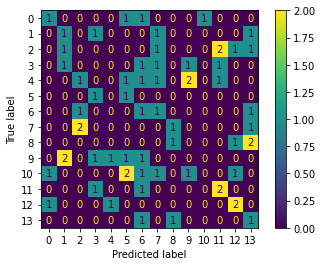

/tmp/ipykernel_2091378/863398745.py:21: RuntimeWarning: divide by zero encountered in true_divide
  mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)
/tmp/ipykernel_2091378/863398745.py:21: RuntimeWarning: invalid value encountered in true_divide
  mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)


Mean accuracy = 0.15384615384615385


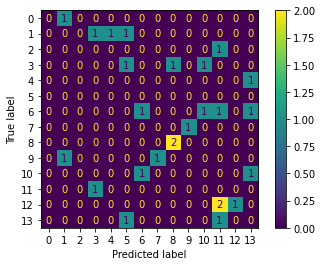

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
confusion_matrix_test_loader = Data.DataLoader(test, batch_size = 64, shuffle = False)
with torch.no_grad():
    list_mean_accuracy = []
    for i, data in enumerate(confusion_matrix_test_loader, 0):
        inputs, labels, bp = data
        inputs, labels, bp = inputs.to(device), labels.type(torch.LongTensor).to(device), bp.to(device)
        outputs = rpsmnet(inputs, bp)
        optimizer.step()          
        _, predicted = torch.max(outputs,1)
        # predicted = torch.max(outputs)
        labels = labels.cpu()
        predicted = predicted.cpu()
        labels = labels.numpy()
        predicted = predicted.numpy()
        # mean_conf_mat = confusion_matrix(labels, predicted)
        # mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
        # mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
        mean_conf_mat = confusion_matrix(labels, predicted)
        mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
        mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1) 
        list_mean_accuracy.append(mean_accuracy)
        print("Mean accuracy = {0}".format(mean_accuracy))
        ConfusionMatrixDisplay.from_predictions(labels, predicted)
        # plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
        plt.show()

In [ ]:
torch.max(Testoutput,1)

torch.return_types.max(
values=tensor([7.1546, 7.4989, 7.2406, 7.4986, 7.0637, 7.2464, 6.8946, 7.2835, 6.9954,
        7.4655, 6.9324, 7.5937, 6.9544, 7.4460, 7.1179, 7.0397, 7.2257, 6.9913,
        7.2716, 7.4679, 7.6336, 7.2738, 6.9536, 7.2841, 7.0433, 7.3976, 7.6335,
        7.2979, 6.8528, 7.0941, 7.5488, 7.7630, 7.2037, 7.3379, 6.7545, 6.9814,
        7.1571, 7.2898, 7.2017, 7.1691, 7.8751, 7.2257], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([12, 11,  5,  2,  8,  1,  2, 13,  4,  6,  5, 10,  4,  7,  5,  6,  7,  8,
         1,  2,  0, 11,  4, 10,  5,  7,  9, 13, 13,  8, 11,  8,  7,  6, 12,  5,
        13,  1, 13, 12,  9,  5], device='cuda:0'))

In [ ]:
val_y

tensor([12, 11,  5,  2,  8,  1,  2, 13,  4,  6,  5, 10,  4,  7,  5,  6,  7,  8,
         1,  2,  0, 11,  4, 10,  5,  7,  9, 13, 13,  8, 11,  8,  7,  6, 12,  5,
        13,  1, 13, 12,  9,  5], device='cuda:0')

In [ ]:
!rm -rf /logs/ # clear logs
# if 'google.colab' in str(get_ipython()): # tensor board
%load_ext tensorboard  
# %tensorboard --logdir logs
%tensorboard --logdir=./models/test

## Test

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#       # super(CNN, self)._init_()
#       super(CNN, self).__init__()
#       self.n_classes = 14
#       n_classes =14
#       self.conv1 = nn.Sequential(
#           nn.Conv2d(
#               in_channels=1,
#               out_channels=32,
#               kernel_size=3,
#               stride=1,
#               padding=1,
#           ),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2,stride=2),
#       )
#       self.conv2 = nn.Sequential(
#           nn.Conv2d(32,64,3,1,1),
#           nn.ReLU(),
#           nn.MaxPool2d (2,2),
#       )
#       # self.fc = nn.Linear(64*7*7,128)
#       self.fc = nn.Linear(139264, 100)
#       self.out = nn.Linear(100,n_classes)
#       self.softmax = nn.Softmax()

#     def forward(self,x):
#       x=self.conv1(x)
#       x=self.conv2(x)
#       # x=x.view(x.size(0),-1)
#       x = torch.flatten(x, 1) # flatten all dimensioxns except batch
#       x=self.fc(x)
#       x=self.out(x)      
#       # output=self.out(x)
#       # return output, x
#       # x=self.softmax(x)
#       return x